# 2 Data Preprocessing
**Objective:** Learn how data needs to be represented for machine learning algorithms to be applied.

In [6]:
from chinese_checkers.game.ChineseCheckersGame import ChineseCheckersGame
from chinese_checkers.model.BootstrapModel import BootstrapModel
from chinese_checkers.simulation.GameSimulation import GameSimulation
from chinese_checkers.simulation.GameSimulationCatalog import GameSimulationCatalog
from chinese_checkers.simulation.GameSimulationData import GameSimulationData

from torch import tensor, stack, zeros_like

from typing import List

import os

## 2.1 State Representation

To represent the `ChineseCheckersGame` state for PyTorch consumption, we must transform the board into a one-hot encoded vector. For a given position on the board, we'll represent each potential player's piece using a binary value: 1 if the player has a piece at that position and 0 otherwise.

Given this, for a board of size `s` with `n` players, the length of our one-hot encoded state vector will be $s \times n$.

For clarity, the one-hot encoded representation is defined as:

$$
p_{i,j} =
\begin{cases}
1 & \ \text{if player } j \text{ has a piece at position } i,\\
0 & \ \text{otherwise.}
\end{cases}
$$

We'll begin by focusing on a board of size 4 with 2 players. Later, we can extend our approach to accommodate different board sizes and player counts.


In [7]:
def generate_tensor_for_game(game: ChineseCheckersGame) -> tensor:
    all_positions = game.board.hexagram_points
    encoded_state = tensor([
        [
            1 if position in player.positions else 0
            for position in all_positions
        ]
        for player in game.players
    ])

    return encoded_state

game = ChineseCheckersGame.start_game(number_of_players=2, board_size=4)
game_state = generate_tensor_for_game(game)
print(game_state)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0]])


## 2.2 Encoding Sequence of Game States

With the capability to encode individual game states, our next step is encoding sequences of game states that represent an entire game. To ensure consistency, we'll set a limit of 400 turns for each game. Each game state within this sequence will occupy a row in our matrix.

In cases where a game concludes before reaching the 400-turn limit, we'll pad the matrix with rows of zeros until it reaches the desired size. This ensures that each game, regardless of its duration, results in a consistent-sized matrix which can be efficiently processed by PyTorch.

In [10]:
def generate_tensor_for_game_sequence(game_sequence: List[ChineseCheckersGame], max_turns = 400):
    game_sequence_tensors = [ generate_tensor_for_game(game_state) for game_state in game_sequence ]

    padding_size = max_turns - len(game_sequence)
    if padding_size > 0:
        padding = [zeros_like(game_sequence_tensors[0])] * padding_size
        game_sequence_tensors.extend(padding)

    return stack(game_sequence_tensors)


# Example usage:
simulation = GameSimulation([BootstrapModel(), BootstrapModel()], max_turns=400)
simulation.simulate_game()
print(f"No. of turns: {len(simulation.move_history)}")
game_sequence = simulation.get_simulation_data("bootstrap_model", "1.1").to_game_sequence()
game_sequence_tensor = generate_tensor_for_game_sequence(game_sequence, simulation.max_turns)
game_sequence_tensor.size()

No. of turns: 375


torch.Size([400, 2, 121])

## 2.3 Generating Data for Training

We have created a `GameSimulationCatalog` class to manage the storage of our training data.  The `GameSimulationCatalog` class is responsible for loading and saving `GameSimulation` objects to disk.  It also provides a convenient interface for loading a `GameSimulationDataset` object which can be used to train a model.  This catalog stores data in a very efficient manner by storing the game state as a list of player ids and their occupied positions.  The tensor representation of the game state can be reconstructed from this data when loaded.

We have run 100,000 games with the bootstrap models and will use this data to train our first neural network.

In [13]:
catalog = GameSimulationCatalog("D:\chinese_checkers_games")

In [14]:
# simulate the games
model_1 = BootstrapModel()
model_2 = BootstrapModel()
for game_number in range(10):
    game_simulation = GameSimulation([model_1, model_2])
    try:
        winner = game_simulation.simulate_game()
        print(f"Game Number {game_number}, Winner {winner.player_id}")
        catalog.save_simulation(game_simulation.export_simulation_data("bootstrap_model", "1.1"))
    except:
        print(f"Game Number {game_number}, Not Completed")

Game Number 0, Winner 3
Game Number 0, Not Completed
Game Number 1, Not Completed
Game Number 2, Winner 3
Game Number 2, Not Completed
Game Number 3, Winner 0
Game Number 3, Not Completed
Game Number 4, Winner 0
Game Number 4, Not Completed
Game Number 5, Winner 3
Game Number 5, Not Completed
Game Number 6, Winner 0
Game Number 6, Not Completed
Game Number 7, Winner 0
Game Number 7, Not Completed
Game Number 8, Winner 0
Game Number 8, Not Completed
Game Number 9, Winner 0
Game Number 9, Not Completed


In [15]:
# list the game dataset that are available
metadata_list = catalog.list_available_metadata()
for metadata in metadata_list:
    simulations = [s for s in catalog.load_simulations_by_metadata(metadata)]
    print(f"Metadata {metadata}, Simulation Count {len(simulations)}")

Metadata GameMetadata(player_count=2, board_size=4, max_game_length=1000, winning_player='0', name='bootstrap_model', version='1.0'), Simulation Count 41908
Metadata GameMetadata(player_count=2, board_size=4, max_game_length=1000, winning_player='0', name='bootstrap_model', version='1.1'), Simulation Count 12
Metadata GameMetadata(player_count=2, board_size=4, max_game_length=1000, winning_player='3', name='bootstrap_model', version='1.0'), Simulation Count 41598
Metadata GameMetadata(player_count=2, board_size=4, max_game_length=1000, winning_player='3', name='bootstrap_model', version='1.1'), Simulation Count 12


In [16]:
# print the first dataset
dataset = next(catalog.load_simulations_by_metadata(metadata_list[0]))
dataset

GameSimulationData(metadata=GameMetadata(player_count=2, board_size=4, max_game_length=1000, winning_player='0', name='bootstrap_model', version='1.0'), positions=GamePositions(player_ids=['0', '3'], player_start_positions=[[(1, 4), (2, 3), (2, 4), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (4, 4)], [(-1, -4), (-2, -3), (-2, -4), (-3, -2), (-3, -3), (-3, -4), (-4, -1), (-4, -2), (-4, -3), (-4, -4)]], player_target_positions=[[(-1, -4), (-2, -3), (-2, -4), (-3, -2), (-3, -3), (-3, -4), (-4, -1), (-4, -2), (-4, -3), (-4, -4)], [(1, 4), (2, 3), (2, 4), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (4, 4)]], historical_moves=[Move(0, -2), Position(2, 4), Move(1, 0), Position(-3, -2), Move(-2, 0), Position(3, 2), Move(0, 2), Position(-1, -4), Move(-2, -2), Position(3, 3), Move(2, 2), Position(-3, -3), Move(0, -1), Position(1, 1), Move(2, 2), Position(-2, -3), Move(0, -2), Position(2, 3), Move(4, 2), Position(-2, -2), Move(-1, 0), Position(2, 1), Move(1, 0), Position(2, 0), Move(-6, -

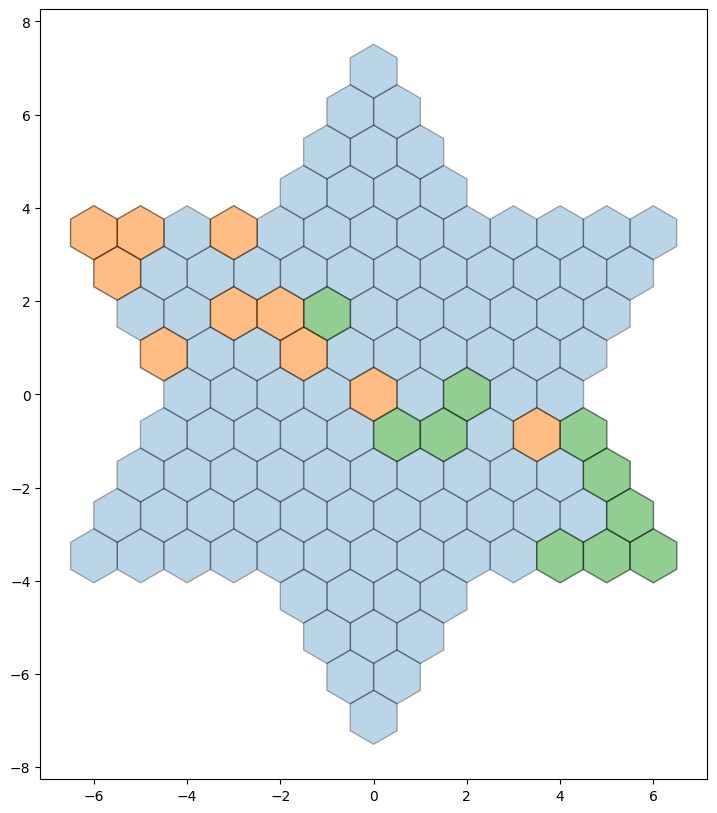

In [17]:
# print the 20th turn in the game
GameSimulationData.to_game_sequence(dataset)[20].print()

In [19]:
# convert the dataset to a tensor
generate_tensor_for_game_sequence(dataset.to_game_sequence(), 400)

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

### Training Data Storage Size Optimization
To ensure we can store enough training data we have optimized how the catalog stores the data.  Let's see how much space our 100,000 games take up.

In [20]:
def get_directory_size(path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            total_size += os.path.getsize(file_path)

    return total_size

def human_readable_size(size, decimal_places=2):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            break
        size /= 1024.0
    return f"{size:.{decimal_places}f} {unit}"

directory_path = "D:\chinese_checkers_games"
total_size = get_directory_size(directory_path)
print(f"Total size of directory '{directory_path}': {human_readable_size(total_size)}")

Total size of directory 'D:\chinese_checkers_games': 905.09 MB


#### Training data Size Limitation
With a 4TB hard drive at our disposal, we have approximately 3.7TB of usable storage space. This allows us to store around 341,296,943 games. While this is a substantial number of games, prudent data storage practices are essential to ensure optimal utilization of the available space.